In [1]:
# this demo generates a waveform
# then fits several networks separately on scaled versions of the
# waveform to show the effect.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

# from scrinet.interfaces import lalutils, rotations 
from wispy import lalutils, rotations 


from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.mscalev4
import wispy.mscalev5
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

In [2]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})


In [3]:
# generate waveforms

1.1785016498623269 1.2246467991473532e-16 -0.0


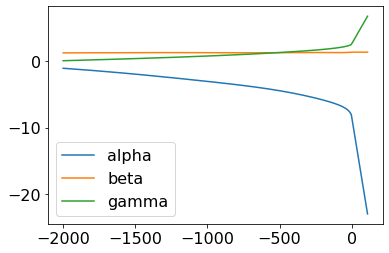

In [4]:
S1x=0.99
S2x=0.99

# S1x=0.
# S2x=0.

params = lalutils.gen_td_modes_wf_params(
    m1=100,
    m2=10,
    approximant=lalsim.SEOBNRv4P,
    S1x=S1x,
    S1y=0.,
    S2x=S2x,
    S2y=0.,
    f_min=12,
    f_ref=12,
    phiRef=1.2)

times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=-2000, t_max=110)

thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(thetaJN, alpha0, phi_aligned)

wr = rotations.WaveformRotations(
    times=times,
    hlms=hlms, 
    frame='inertial-L',
    alpha0=alpha0,
    thetaJN=thetaJN,
    phi0=phi_aligned) 

wr.from_inertial_frame_to_coprecessing_frame()

plt.figure()
plt.plot(wr.times, wr.alpha, label='alpha')
plt.plot(wr.times, wr.beta, label='beta')
plt.plot(wr.times, wr.gamma, label='gamma')
plt.legend()

wr.from_coprecessing_frame_to_inertial_frame()

In [5]:
# preprocess waveforms

In [6]:
# scale times
# times_scaler = MinMaxScaler(feature_range=(-1,0))
# times_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
# times_scaler = MinMaxScaler(feature_range=(-0.1, 0.1))
# times_scaler = MinMaxScaler(feature_range=(-4,4))
times_scaler = MinMaxScaler(feature_range=(-1,1))
# times_scaler = MinMaxScaler(feature_range=(-0.1,0))
X_train_base = times_scaler.fit_transform(times[:,np.newaxis])

In [7]:
X_train_base

array([[-1.        ],
       [-0.99957283],
       [-0.99914566],
       ...,
       [ 0.99914566],
       [ 0.99957283],
       [ 1.        ]])

In [8]:
scale_22 = np.abs(wr.hlms[(2,2)]).max()
print(scale_22)
# y_train = np.column_stack(
#     (wr.hlms[(2,2)].real/scale_22,wr.hlms[(2,2)].imag/scale_22)
# )

y_train = np.abs(wr.hlms[(2,2)])/scale_22
y_train = y_train[:, np.newaxis]

0.10620956808412164


In [9]:
y_train

array([[0.19542968],
       [0.19161033],
       [0.18772867],
       ...,
       [0.00097104],
       [0.00093576],
       [0.00089894]])

In [10]:
X_train_base.shape

(4683, 1)

In [11]:
y_train.shape

(4683, 1)

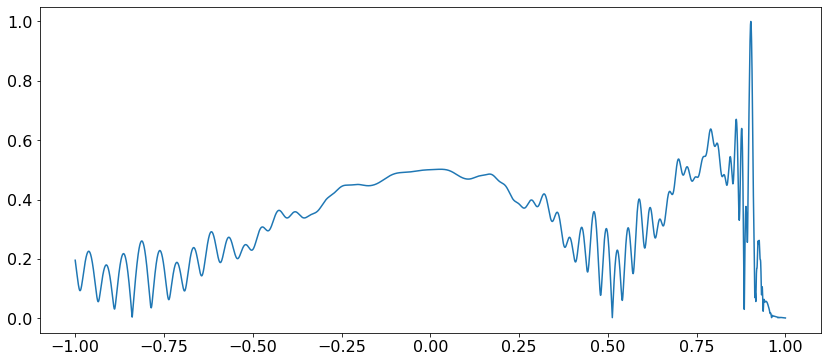

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(X_train_base[:,0], y_train[:,0])

In [13]:
def build_model(units=32, activation_1='relu', activation='relu', lr=1e-3, kernel_initializer='glorot_uniform'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(units, activation_1, kernel_initializer=kernel_initializer),
        tf.keras.layers.Dense(units, activation),
        tf.keras.layers.Dense(units, activation),
        tf.keras.layers.Dense(1, activation='linear'),
    ])
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    
    return model

In [14]:
# check prior dist.

In [101]:
m_prior = build_model(units=100, activation_1='s2relu', activation='relu', lr=1e-4)

In [102]:
y_prior_base = m_prior.predict(X_train_base)
y_prior_base_sc_2 = m_prior.predict(X_train_base*20)



times_scaler_2 = MinMaxScaler(feature_range=(0,1))
X_2 = times_scaler_2.fit_transform(times[:,np.newaxis])
y_prior_sc_20 = m_prior.predict(X_2 * 20)
y_prior_sc_1 = m_prior.predict(X_2)

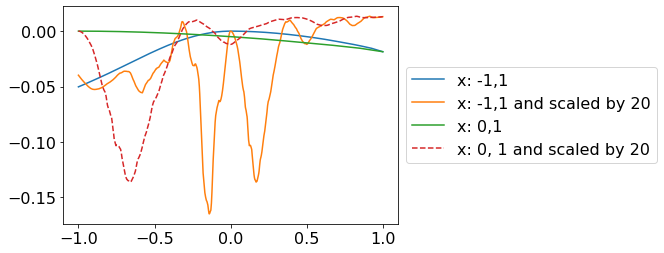

In [103]:
plt.figure()
plt.plot(X_train_base, y_prior_base, label='x: -1,1')
plt.plot(X_train_base, y_prior_base_sc_2, label='x: -1,1 and scaled by 20')
plt.plot(X_train_base, y_prior_sc_1, label='x: 0,1')
plt.plot(X_train_base, y_prior_sc_20, label='x: 0, 1 and scaled by 20', ls='--')
# plt.plot(X_2, y_prior_sc)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [113]:
# checking for very wide networks
# the blue network (in the plot below) seems to
# loose it's variability when the width becomes very wide...
# hmmm maybe not true.
m_prior = build_model(units=1000, activation_1='s2relu', activation='relu', lr=1e-4)

In [114]:
y_prior_base = m_prior.predict(X_train_base)
y_prior_base_sc_2 = m_prior.predict(X_train_base*20)



times_scaler_2 = MinMaxScaler(feature_range=(0,1))
X_2 = times_scaler_2.fit_transform(times[:,np.newaxis])
y_prior_sc_20 = m_prior.predict(X_2 * 20)
y_prior_sc_1 = m_prior.predict(X_2)

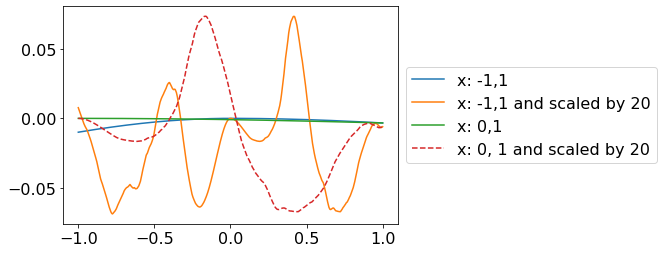

In [115]:
plt.figure()
plt.plot(X_train_base, y_prior_base, label='x: -1,1')
plt.plot(X_train_base, y_prior_base_sc_2, label='x: -1,1 and scaled by 20')
plt.plot(X_train_base, y_prior_sc_1, label='x: 0,1')
plt.plot(X_train_base, y_prior_sc_20, label='x: 0, 1 and scaled by 20', ls='--')
# plt.plot(X_2, y_prior_sc)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
X_train_base.shape

(4683, 1)

In [125]:
# loop over scales
def loop_scales_test(x_shift=0, xmin=-1, xmax=1, scales=[1,2,3,4,5], units=128, kernel_initializer='glorot_uniform'):
    x = np.linspace(xmin, xmax, 1000)

    plt.figure()
    for scale in scales:
        m = build_model(units=units, activation_1='s2relu', activation='relu', lr=1e-4, kernel_initializer=kernel_initializer)
        y = m.predict((x+x_shift)*scale)
        plt.plot(x, y, label=f"{scale}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

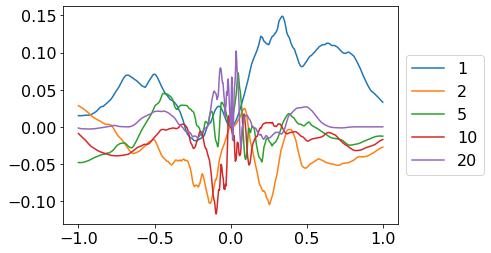

In [159]:
kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1)
# kernel_initializer=tf.keras.initializers.GlorotNormal()
# kernel_initializer=tf.keras.initializers.GlorotUniform()
loop_scales_test(x_shift=0, xmin=-1, xmax=1, scales=[1,2,5,10,20], kernel_initializer=kernel_initializer)

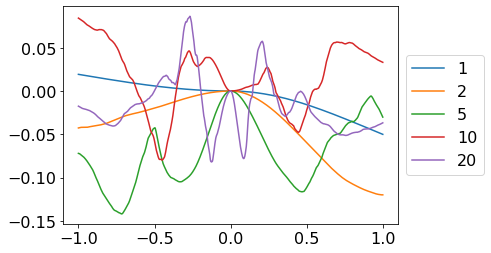

In [160]:
# kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1)
# kernel_initializer=tf.keras.initializers.GlorotNormal()
kernel_initializer=tf.keras.initializers.GlorotUniform()
loop_scales_test(x_shift=0, xmin=-1, xmax=1, scales=[1,2,5,10,20], kernel_initializer=kernel_initializer)

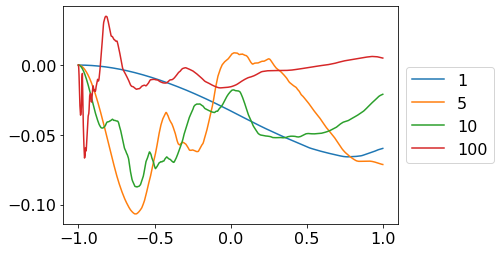

In [161]:
loop_scales_test(x_shift=1, xmin=-1, xmax=1, scales=[1,5,10,100])

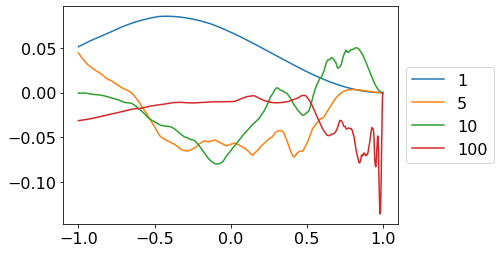

In [162]:
loop_scales_test(x_shift=-1, xmin=-1, xmax=1, scales=[1,5,10,100])

In [75]:
%%time
# scales = [1, 10, 50]
# scales = [1]
scales = [4]
# scales = [4, 10]
# scales = [10, 20]

# epochs=2000
# epochs=3000
epochs=4000
# batch_size=len(y_train)//4
# batch_size=len(y_train)//10
batch_size=128
# batch_size=64


print(f"batch_size: {batch_size}")


X_train = {}

models = {}
histories = {}

yhats = {}

for i, scale in enumerate(scales):
    print(f"{i+1}/{len(scales)}")
    X_train[scale] = (X_train_base) * scale
    
    kernel_initializer=tf.keras.initializers.GlorotNormal()
#     kernel_initializer=tf.keras.initializers.GlorotUniform()
    m = build_model(units=128, activation_1='s2relu', activation='s2relu', lr=1e-4, kernel_initializer=kernel_initializer)
    h = m.fit(X_train[scale], y_train, epochs=epochs, verbose=0, batch_size=batch_size)
    
    yhats[scale] = m.predict(X_train[scale])
    
    models[scale]=m
    histories[scale]=h

batch_size: 128
1/1
CPU times: user 6min 16s, sys: 1min 55s, total: 8min 11s
Wall time: 2min 48s


In [76]:
for k in histories.keys():
    print(f"{k}: {histories[k].history['loss'][-1]}")

4: 4.772402098751627e-05


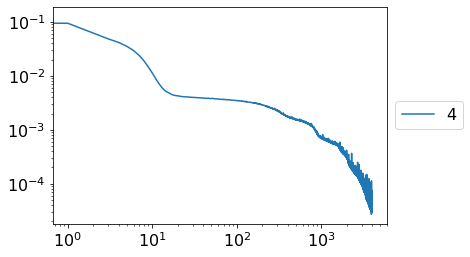

In [77]:
plt.figure()
for k in histories.keys():
    plt.plot(histories[k].history['loss'], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.xscale('log')

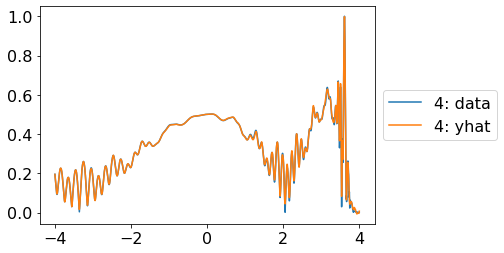

In [78]:
for k in yhats.keys():
    plt.figure()
    plt.plot(X_train[k], y_train, label=f'{k}: data')
    plt.plot(X_train[k], yhats[k], label=f'{k}: yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

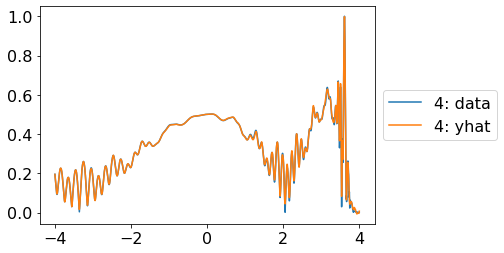

In [79]:
for i, k in enumerate(yhats.keys()):
    plt.figure()
    plt.plot(X_train[k], y_train, label=f'{k}: data')
    plt.plot(X_train[k], yhats[k], label=f'{k}: yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(0.2*scales[i], 0.7*scales[i])
#     plt.xlim(0., 0.1*scales[i])

(-0.75, 1.0)

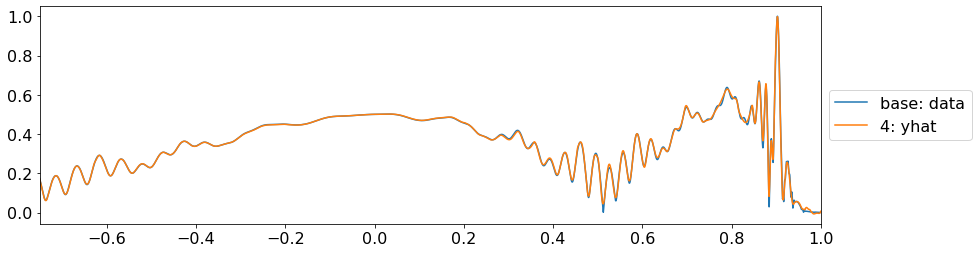

In [80]:
plt.figure(figsize=(14,4))
plt.plot(X_train_base, y_train, label=f'base: data')
for k in yhats.keys():
    plt.plot(X_train_base, yhats[k], label=f'{k}: yhat')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-0.75, 1)

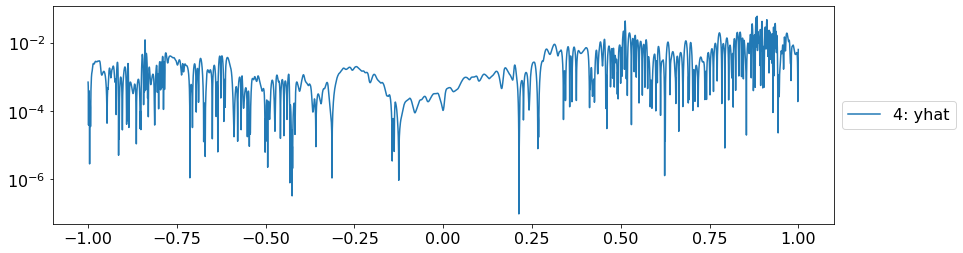

In [81]:
plt.figure(figsize=(14,4))
for i, k in enumerate(yhats.keys()):
    plt.plot(X_train_base, np.abs(y_train-yhats[k]), label=f'{k}: yhat', alpha=0.99*(i+1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

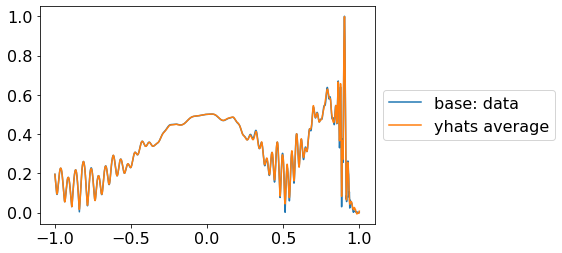

In [82]:
y_hat_final=[]

plt.figure()
plt.plot(X_train_base, y_train, label=f'base: data')
for k in yhats.keys():
    y_hat_final.append(yhats[k][:,0])
    
y_hat_final = np.asarray(y_hat_final).sum(axis=0)/len(scales)
plt.plot(X_train_base, y_hat_final, label=f'yhats average')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-0.2, 0.)

(0.3, 1.0)

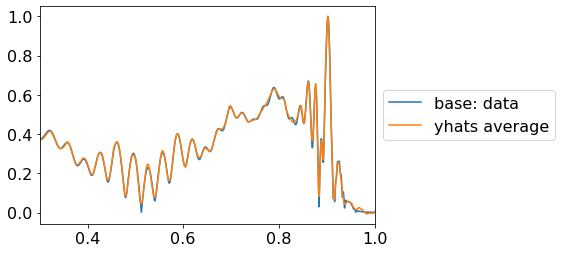

In [83]:
y_hat_final=[]

plt.figure()
plt.plot(X_train_base, y_train, label=f'base: data')
for k in yhats.keys():
    y_hat_final.append(yhats[k][:,0])
    
y_hat_final = np.asarray(y_hat_final).sum(axis=0)/len(scales)
plt.plot(X_train_base, y_hat_final, label=f'yhats average')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0.3, 1)